In [1]:
import math
import sys

import IPython
import IPython.display as ipd
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

%matplotlib inline
#%matplotlib notebook

from matplotlib import rcParams
rcParams["figure.max_open_warning"] = False

In [8]:
def get_psd(signals_f, ax=None):
    # signals_f shape: times, 4, 32
    # read off from plot: 
    slope = (4000 - 1000) / (285 - 90)
    offset = -500
    delta = 50

    # freqs_window = offset + slope * times
    times_window = (frequencies - offset) / slope
    
    if ax is not None:
        ax.plot(times_window-delta, frequencies, color='red')
        ax.plot(times_window+delta, frequencies, color='red')

    psd = np.zeros(signals_f.shape[1:]) # 4 x 32
    times = np.arange(signals_f.shape[0])
    for i, (t, f) in enumerate(zip(times_window, frequencies)):
        signals_window = signals_f[(times <= t + delta) & (times >= t - delta),:,i]
        psd[:, i] = np.sum(np.abs(signals_window)**2 /(2*delta), axis=0) / signals_window.shape[0]
    return psd

Appending to evaluate_data.py


In [7]:
from evaluate_data import read_df, integrate_yaw
from dynamic_analysis import add_pose_to_df

exp_name = '2020_11_23_wall2'; 

df_total = pd.DataFrame(columns=['signals_f', 'degree', 'yaw', 'distance', 'source', 'psd', 'spec', 'frequencies'])

params = dict(
  props = False,
  snr = False,
  motors = False,
  exp_name = exp_name
)
for degree in [0, 27, 54, 81, 360]:
    for distance in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        for source in ['mono4125', None, 'sweep']:
            try:
                params['degree'] = degree
                params['distance'] = distance
                params['source'] = source
                if distance in [10, 30, 50]:
                    params['appendix'] = "_new"
                else:
                    params['appendix'] = ""
                df, df_pos = read_df(**params)
            except Exception as e:
                continue 
                
            # detect index decrease (happens when two csv files are concatenated)
            sign = np.sign(df['index'].values[1:] - df['index'].values[:-1])
            if np.any(sign < 0):
                index = np.where(sign<0)[0][-1]
                print('Warning: found multiple start indices, start at', index)
                df = df.iloc[index:]
                index_start = df.iloc[0]['index']
                df_pos = df_pos.loc[df_pos.index >= index_start]
            
            signals_f = np.array([*df.signals_f.values]) # times x 
            print(signals_f.shape)
            frequencies_matrix = np.array([*df.loc[:,'frequencies']])
            frequencies = frequencies_matrix[0, :]
            assert not np.any(np.any(frequencies_matrix - frequencies[None, :], axis=0))
            
            if degree == 360:
                add_pose_to_df(df, df_pos, max_allowed_lag_ms=50)
                yaw = integrate_yaw(df.timestamp.values, df.yaw_rate_deg.values)
            else:
                yaw = np.full(len(df), -degree)
            
            spec = np.sum(np.abs(signals_f), axis=1)
            
            psd = get_psd(signals_f)
            
            df_total.loc[len(df_total), :] = dict(
                degree=degree,
                yaw=yaw,
                distance=distance,
                source=str(source),
                signals_f=signals_f,
                frequencies=frequencies,
                spec=spec,
                psd=psd
            )
            break
        break
    break

read ../experiments/2020_11_23_wall2/csv_files/nomotors_nosnr_noprops_sweep_0.csv
(376, 4, 32)


In [ ]:
fname = f'results/{exp_name}_wall.pkl'
pd.to_pickle(df_total, fname)
print('saved as', fname)

# Fixed angle analysis

[0 10 20 30 40 50 60 70 80 90]
[0 27 54 81 360]
['sweep' 'mono4125' 'None']


Text(0.5, 1.0, 'degree 0, distance 50')

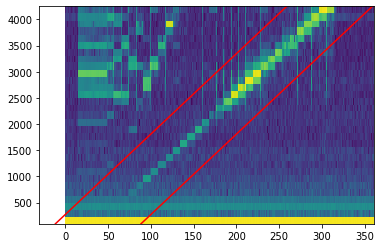

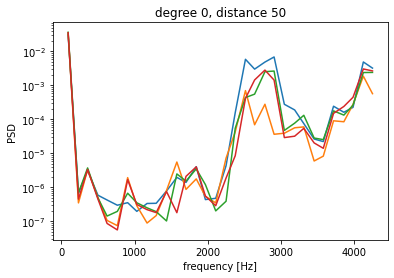

In [3]:
fname = f'results/{exp_name}_wall.pkl'
df_total = pd.read_pickle(fname)
frequencies = df_total.iloc[0].frequencies

print(df_total.distance.unique())
print(df_total.degree.unique())
print(df_total.source.unique())

row = df_total[(df_total.distance==90) & (df_total.degree==81) & (df_total.source=='sweep')].iloc[0]
spec = get_spec(row.signals_f)

# spec
plt.figure()
times = np.arange(spec.shape[0])
plt.pcolormesh(times, frequencies, np.log10(spec.T))

psd = get_psd(row.signals_f, ax=plt.gca())

plt.figure()
for i_mic in range(psd.shape[0]):
    plt.semilogy(frequencies, np.abs(psd[i_mic, :]), label=f"mic{i_mic}")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.title(f'degree {degree}, distance {distance}')

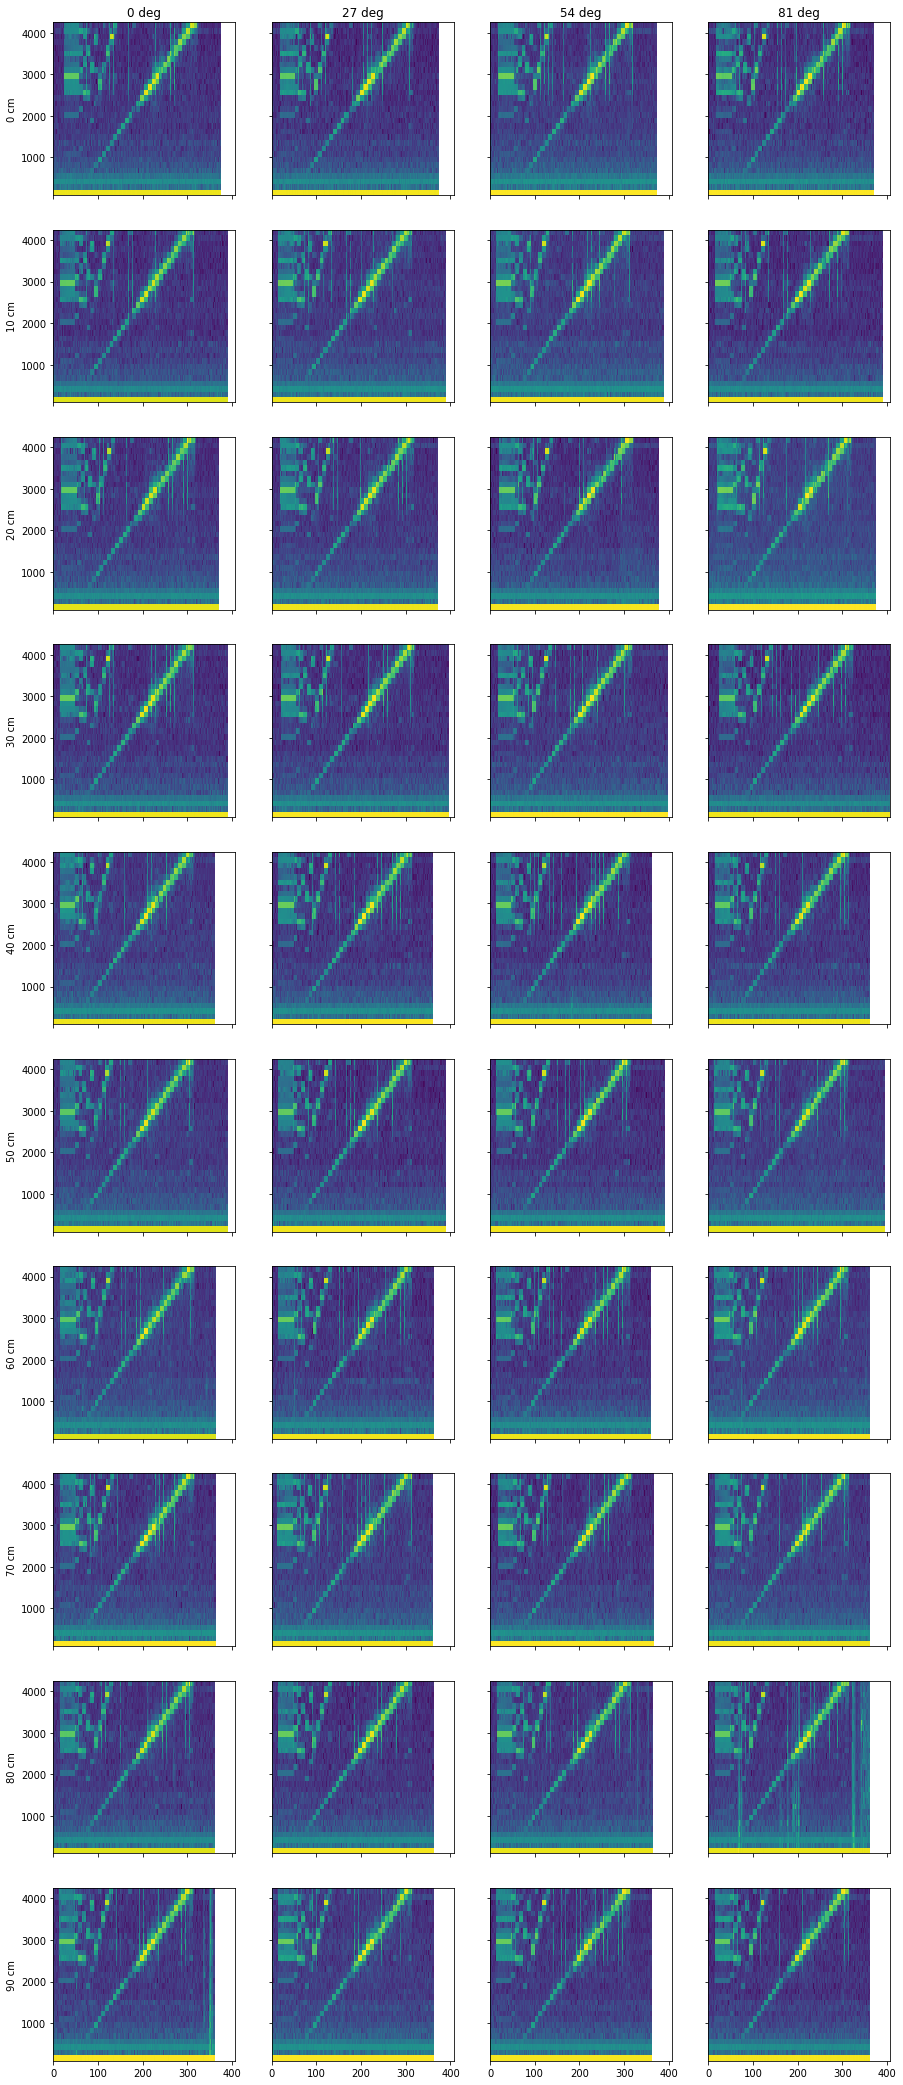

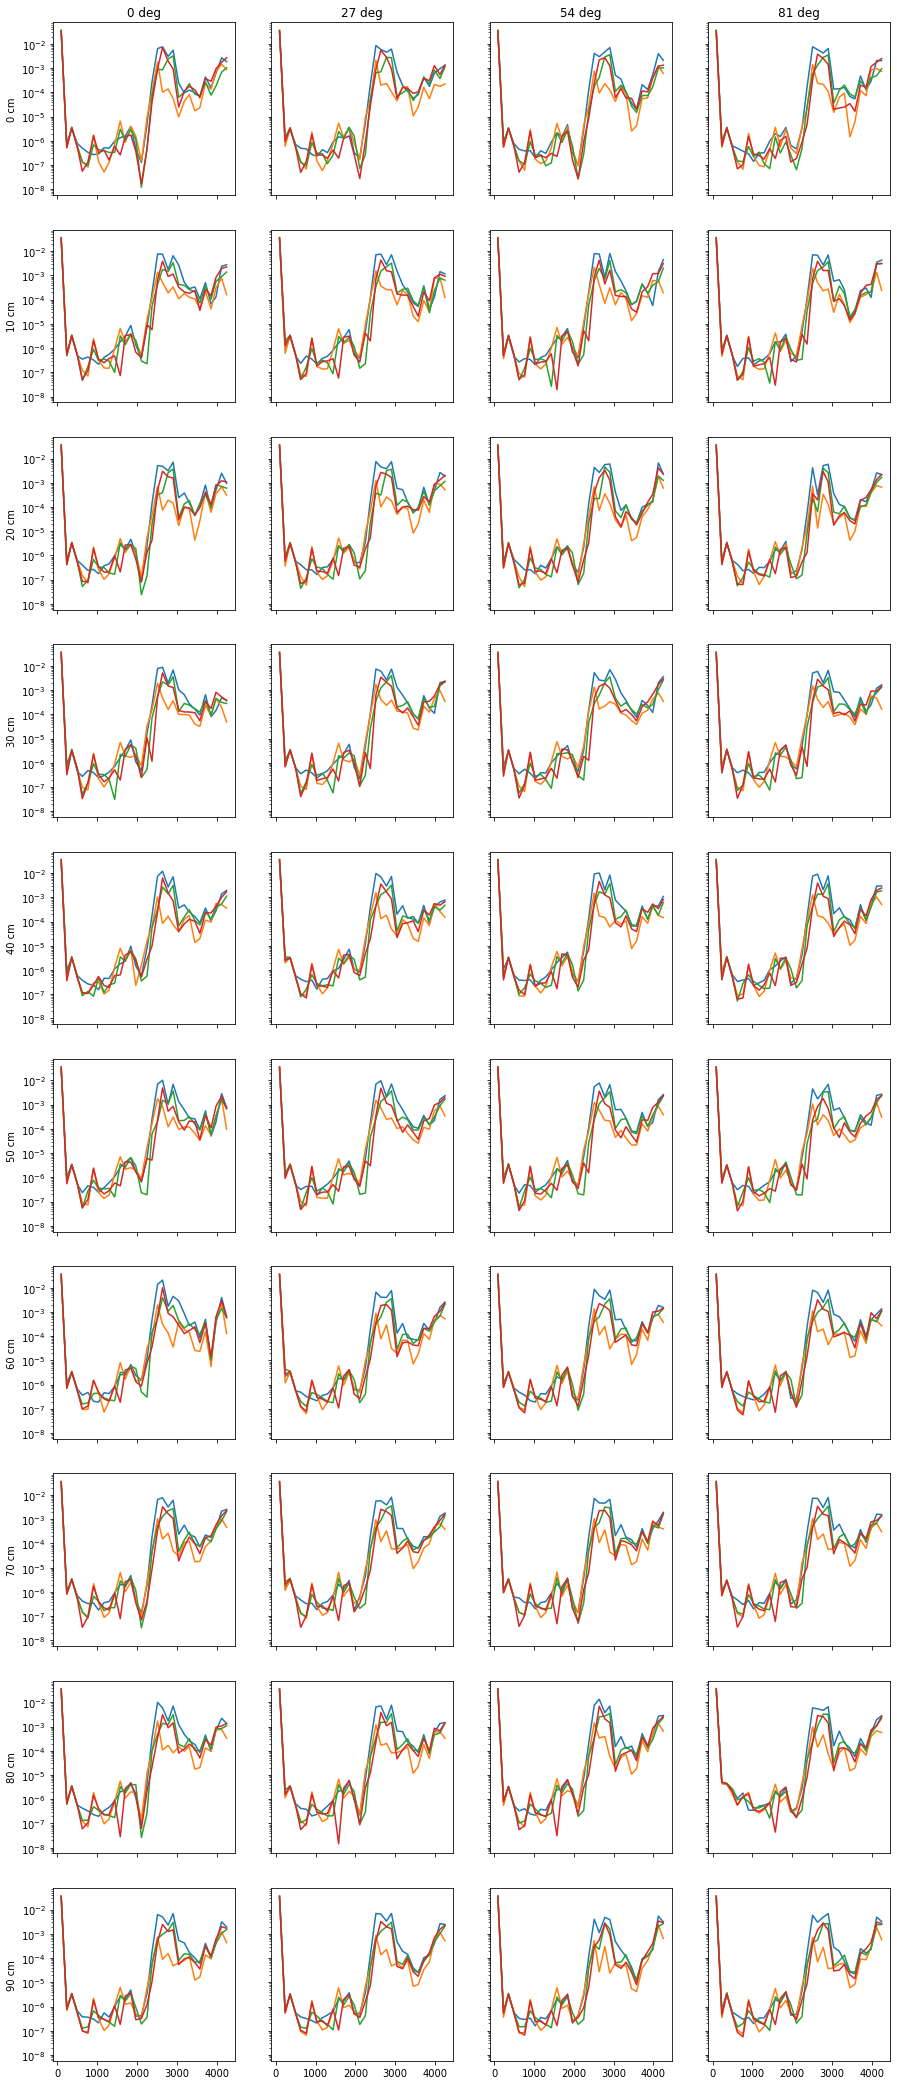

In [4]:
degrees = [d for d in df_total.degree.unique() if d != 360]
distances = df_total.distance.unique()
source = 'sweep'

fig, axs = plt.subplots(len(distances), len(degrees), sharex=True, sharey=True)
fig.set_size_inches(15, 15*axs.shape[0]/axs.shape[1])

fig_psd, axs_psd = plt.subplots(len(distances), len(degrees), sharex=True, sharey=True)
fig_psd.set_size_inches(15, 15*axs.shape[0]/axs.shape[1])
for i, distance in enumerate(distances):
    for j, degree in enumerate(degrees):
        df_this = df_total.loc[(df_total.distance == distance)
                               & (df_total.degree == degree)
                               & (df_total.source == source)]
        row = df_this.iloc[0]
        spec = row.spec
        psd = row.psd
        
        axs[i, j].pcolormesh(range(spec.shape[0]), frequencies, np.log10(spec.T))
        for i_mic in range(psd.shape[0]):
            axs_psd[i, j].semilogy(frequencies, np.abs(psd[i_mic, :]), label=f"mic{i_mic}")
        axs[0, j].set_title(f'{degree} deg')
        axs_psd[0, j].set_title(f'{degree} deg')
    axs[i, 0].set_ylabel(f'{distance} cm')
    axs_psd[i, 0].set_ylabel(f'{distance} cm')

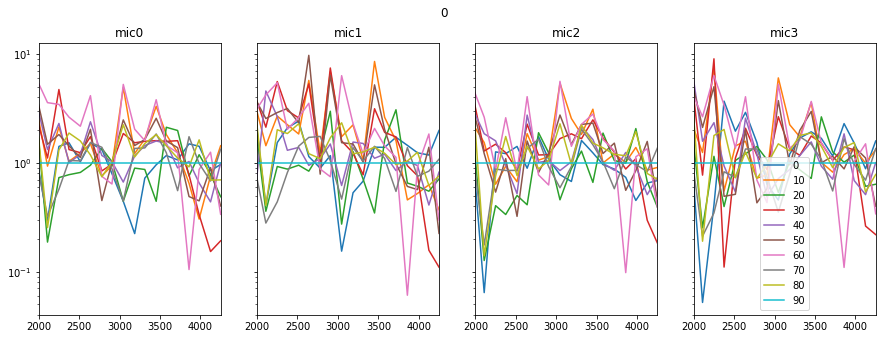

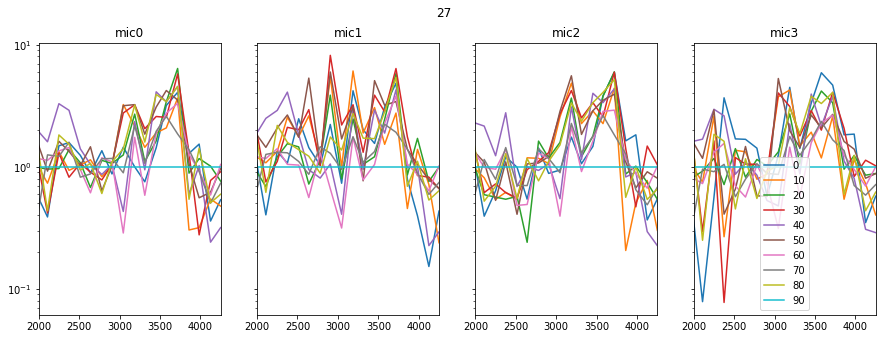

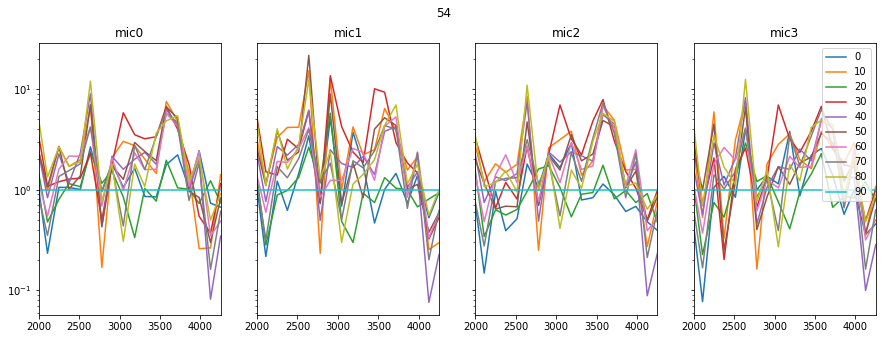

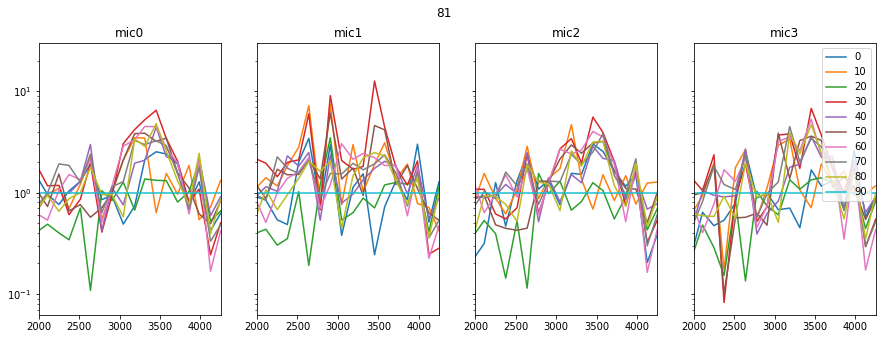

In [6]:
from constants import SPEED_OF_SOUND

distance_ref = 90
distances = df_total.distance.unique()
source = 'sweep'
n_mics = 4
    
for degree in [0, 27, 54, 81]:
    
    df_ref = df_total.loc[(df_total.distance == distance_ref)
                           & (df_total.degree == degree)
                           & (df_total.source == source)]

    fig, axs = plt.subplots(1, n_mics, sharex=True, sharey=True)
    fig.set_size_inches(15, 5)
    
    for mic in range(n_mics):
        psd_ref = df_ref.iloc[0].psd[mic]
        for i, distance in enumerate(distances):
            df_this = df_total.loc[(df_total.distance == distance)
                                   & (df_total.degree == degree)
                                   & (df_total.source == source)]
            #axs[mic].semilogy(frequencies, df_this.iloc[0].psd[mic], label=distance, color=f"C{i}")
            axs[mic].semilogy(frequencies, df_this.iloc[0].psd[mic] / psd_ref, label=distance, color=f"C{i}")
            #axs[mic].plot(frequencies, df_this.iloc[0].psd[mic] - psd_ref, label=distance, color=f"C{i}")

        #axs[mic].set_xlim(min(frequencies), max(frequencies))
        axs[mic].set_xlim(2000,  max(frequencies))
        axs[mic].set_title(f"mic{mic}")
    
    fig.suptitle(degree)
    axs[mic].legend()

In [ ]:
#chosen_frequencies = frequencies[[10, 20, 30]]
chosen_frequencies = frequencies[[30]]
print(chosen_frequencies)

distance_ref = 90
mic = 0

for degree in [0, 27, 54, 81]:
    distances = df_total.distance.unique()
    source = 'sweep'

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)
    for i, distance in enumerate(distances):
        df_this = df_total.loc[(df_total.distance == distance)
                               & (df_total.degree == degree)
                               & (df_total.source == source)]
        row = df_this.iloc[0]
        for f, freq in enumerate(chosen_frequencies):
            chosen_idx = np.where(frequencies == freq)[0][0]
            ax.scatter(distance, row.psd[mic, chosen_idx], color=f"C{f}")
    ax.set_title(degree)
    #ax.set_yscale('log')
    ax.legend(chosen_frequencies)

# Moving analysis

In [ ]:
#freq = 4125
#source = 'None'
source = 'mono4125'
degree = 360

distances = df_total.distance.unique()
chosen_idx = np.where(frequencies == freq)[0][0]

averages = []
for i, distance in enumerate(distances):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(15, 5)
    
    ax = axs[0]
    df_this = df_total.loc[(df_total.distance == distance)
                           & (df_total.degree == degree)]
    df_this = df_this.loc[df_this.source == source]
                           
    signals_f = df_this.iloc[0].signals_f
    yaw =  df_this.iloc[0].yaw
    spec = df_this.iloc[0].spec

    for j in range(signals_f.shape[1]):
        ax.semilogy(range(signals_f.shape[0]), np.abs(signals_f[:, j, chosen_idx]), color=f"C{j}", label=f"mic{j}")

    yaw[np.isnan(yaw)] = 0
    axs[1].plot(range(signals_f.shape[0]), yaw)
    for deg in -np.arange(1, 5)*90:
        index = np.nanargmin(np.abs(yaw-deg))
        axs[1].axvline(x=index, color='C1')
        ax.axvline(x=index, color='C1')
        
    min_avg = 200
    max_avg = 300
    averages.append(np.sum(spec[min_avg:max_avg, chosen_idx], axis=0))
        
    ax.set_title(distance)
    ax.set_ylim(0.05, 10)
    ax.legend()
    [ax.grid() for ax in axs]

In [ ]:
plt.figure()
plt.scatter(distances, averages)
plt.xlabel('distance [cm]')
plt.title(f'average PSD at {freq} Hz')